## NBA Career Prediction Experiment

In [250]:
experiment_label = 'gb02c'

### Aim:
* To see how we can improve the GradientBoostingClassifier by altering SMOTE or undersampling, and by pruning features.

* To improve on gb02b, which scored 0.71073 on Kaggle.



### Findings:

* Kaggle score = 0.70973



## Set up

In [251]:
import pandas as pd
import numpy as np
from joblib import dump, load  # simpler than pickle!
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [252]:
#load data

data_path = '../data/raw/uts-advdsi-nba-career-prediction'

train_raw = pd.read_csv(data_path + '/train.csv')
test_raw = pd.read_csv(data_path + '/test.csv')


In [253]:
#shapes & head

print(train_raw.shape)
print(test_raw.shape)

train_raw.head()

(8000, 22)
(3799, 21)


,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [254]:
test_raw.head()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,...,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,...,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,...,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,...,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,...,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [255]:
# info
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id_old       8000 non-null   int64  
 1   Id           8000 non-null   int64  
 2   GP           8000 non-null   int64  
 3   MIN          8000 non-null   float64
 4   PTS          8000 non-null   float64
 5   FGM          8000 non-null   float64
 6   FGA          8000 non-null   float64
 7   FG%          8000 non-null   float64
 8   3P Made      8000 non-null   float64
 9   3PA          8000 non-null   float64
 10  3P%          8000 non-null   float64
 11  FTM          8000 non-null   float64
 12  FTA          8000 non-null   float64
 13  FT%          8000 non-null   float64
 14  OREB         8000 non-null   float64
 15  DREB         8000 non-null   float64
 16  REB          8000 non-null   float64
 17  AST          8000 non-null   float64
 18  STL          8000 non-null   float64
 19  BLK   

In [256]:
#variable descriptions
train_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576663,7.267087,2.807037,6.231213,44.608900,0.264525,0.816563,...,1.947787,71.365825,1.077838,2.168500,3.245300,1.624513,0.648688,0.245212,1.257762,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [257]:
test_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,...,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,7010.614109,1899.000000,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,...,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,3954.173641,1096.821164,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,...,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,1.000000,0.000000,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,...,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,3644.000000,949.500000,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,...,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,7062.000000,1899.000000,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,...,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,10402.500000,2848.500000,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,...,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,13792.000000,3798.000000,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,...,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


## Decisions

For XGBoost we will retain all potential features.

and TARGET_5Yrs is our target.

## Cleaning

In [258]:
train = train_raw.copy()
test = test_raw.copy()

In [259]:
cols_drop = ['Id_old', 'Id', 'MIN', 'FGM', 'FGA', 'TOV', '3PA', 'FTM', 'FTA', 'REB']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

In [260]:
train.head()

,GP,PTS,FG%,3P Made,3P%,FT%,OREB,DREB,AST,STL,BLK,TARGET_5Yrs
0,80,7.8,45.7,0.1,22.6,72.1,2.2,2.0,3.2,1.1,0.2,1
1,75,10.5,55.1,-0.3,34.9,67.8,3.6,3.7,0.7,0.5,0.6,1
2,85,4.5,42.8,0.4,34.3,75.7,0.6,1.8,0.8,0.4,0.2,1
3,63,8.2,52.5,0.3,23.7,66.9,0.8,2.0,1.8,0.4,0.1,1
4,63,3.7,50.8,0.5,13.7,54.0,2.4,2.7,0.4,0.4,0.6,1


In [261]:
test.head()

,GP,PTS,FG%,3P Made,3P%,FT%,OREB,DREB,AST,STL,BLK
0,56,4.0,43.7,0.1,7.3,63.4,1.2,0.8,0.4,0.2,0.3
1,43,10.1,46.0,0.6,35.1,75.3,0.5,0.9,3.5,0.6,0.0
2,82,11.3,45.6,0.5,44.8,71.2,1.3,3.3,2.5,1.3,0.3
3,86,18.8,42.9,0.5,13.5,70.9,1.5,3.2,4.1,0.9,0.1
4,58,4.7,40.0,0.5,38.7,76.9,0.2,0.6,1.5,0.5,-0.4


In [262]:
train_target = train.pop('TARGET_5Yrs')

In [263]:
#examine shapes

print('train:' + str(train.shape))
print('test:' + str(test.shape))

train:(8000, 11)
test:(3799, 11)


In [264]:
# target class balance check
from collections import Counter

counter = Counter(train_target)
print(counter)

Counter({1: 6669, 0: 1331})


# Modelling

In [265]:
#transformations

# scaling - not for tree-based model


In [286]:
# class imbalance pipeline

!pip install imblearn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import Pipeline



In [287]:
# split training into train & validation

validation = False

if validation:
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(train, train_target, test_size=0.2, random_state=8)
else:
    #in this case we will use CV
    X_train, y_train = train, train_target


In [288]:
#import models

from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#from sklearn.model_selection import cross_val_score


In [315]:
# Define model
classifier = GradientBoostingClassifier(random_state=8)

# Define parameters
param_grid = {
        'model__n_estimators': [60, 70],
        'model__learning_rate': [0.08, 0.09],
        'model__max_depth': [2,3]
}

# Define cv
cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=8
)

# Define model pipeline
model = Pipeline([
        #('over', SMOTE(sampling_strategy=0.25)),    
        ('over', RandomOverSampler(sampling_strategy=0.25)),
        ('under', RandomUnderSampler(sampling_strategy=0.5)),
        ('model', classifier)
    ])

# Define grid search
grid = GridSearchCV(estimator=model,
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=cv)


In [316]:
# Fit model

grid.fit(X_train, y_train)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=8),
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(sampling_strategy=0.25)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        GradientBoostingClassifier(random_state=8))]),
             param_grid={'model__learning_rate': [0.08, 0.09],
                         'model__max_depth': [2, 3],
                         'model__n_estimators': [60, 70]},
             scoring='roc_auc')

In [317]:
# can use this to get best result but doesn't actually do the fitting??

#scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
#from numpy import mean
#print('Mean ROC AUC: %.3f' % mean(scores))

In [318]:
# Score of best model

mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

grid.best_params_, mean_score, std_score

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__learning_rate': 0.09, 'model__max_depth': 2, 'model__n_estimators': 70}
Mean CV score:  0.698190
Standard deviation of CV score:  0.024428


In [319]:
#save model to file

dump(grid,  '../models/aj_' + experiment_label + '.joblib')

['../models/aj_gb02c.joblib']

In [320]:
#predictions for train set

y_train_preds = grid.predict(X_train)

if validation:
    y_val_preds = grid.predict(X_val)

## Evaluation

In [321]:
from sklearn import metrics


In [322]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.models.aj_metrics import confusion_matrix

In [324]:
# Show TRAINING confusion matrix with labels

print("Training:")
print(confusion_matrix(y_train, y_train_preds))

if validation:
    print("Val:")
    print(confusion_matrix(y_val, y_val_preds))

Training:
        pred:0  pred:1
true:0     385     946
true:1     587    6082


In [325]:
print(metrics.classification_report(y_train, y_train_preds))
if validation:
    print(metrics.classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.40      0.29      0.33      1331
           1       0.87      0.91      0.89      6669

    accuracy                           0.81      8000
   macro avg       0.63      0.60      0.61      8000
weighted avg       0.79      0.81      0.80      8000



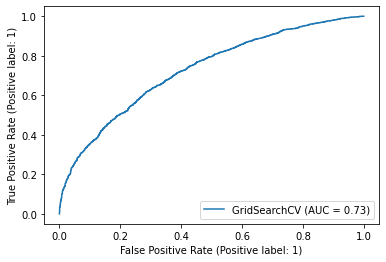

In [326]:
import matplotlib.pyplot as plt  
from sklearn import metrics
metrics.plot_roc_curve(grid, X_train, y_train)
plt.show() 
if validation:
    metrics.plot_roc_curve(grid, X_val, y_val)
    plt.show() 

# Apply to test data for submission

In [327]:
y_test_preds = grid.predict(test)


In [328]:
y_test_preds

array([1, 1, 1, ..., 0, 1, 1])

In [329]:
y_test_probs = grid.predict_proba(test)

In [330]:
y_test_probs

array([[0.43207392, 0.56792608],
       [0.34402161, 0.65597839],
       [0.16261378, 0.83738622],
       ...,
       [0.53267603, 0.46732397],
       [0.14103046, 0.85896954],
       [0.40650539, 0.59349461]])

In [331]:
len(y_test_probs)

3799

In [332]:
test_raw.shape

(3799, 21)

In [333]:
test_raw['Id'].shape

(3799,)

In [334]:
submission = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p[1] for p in y_test_probs]})

In [335]:
submission.head()

,Id,TARGET_5Yrs
0,0,0.567926
1,1,0.655978
2,2,0.837386
3,3,0.838639
4,4,0.602552


In [336]:
submission.to_csv('../reports/aj_' + experiment_label + 'submission.csv',
                 index=False,
                 )